In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class, get_dataloader
from src.model.sequence_classification.trainer import SequenceClassificationTrainer

import re
from typing import List, Dict
    

import warnings
warnings.filterwarnings("ignore")

In [3]:
notebook_login()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "Finetuning"
dataset_name = "RAFT-ONE-STOP-ENGLISH"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


## Get data

In [5]:
one_stop_english_dataset = load_dataset(
    "ought/raft", 
    name="one_stop_english" , 
    cache_dir= "/Data/pedro.silva"
)

In [6]:
train_dataset = one_stop_english_dataset['train'].add_column(
    "labels",
    list(map(lambda x: x- 1, one_stop_english_dataset['train']['Label']))
)

test_dataset = one_stop_english_dataset['test'].add_column(
    "labels",
    list(map(lambda x: x- 1, one_stop_english_dataset['test']['Label']))
)

In [7]:
classes = np.unique(train_dataset['labels'], return_counts=True)
classes

(array([0, 1, 2]), array([18, 20, 12]))

In [8]:
num_classes = len(classes[0])
num_classes

3

In [9]:
train_dataset

Dataset({
    features: ['Article', 'ID', 'Label', 'labels'],
    num_rows: 50
})

In [10]:
classes_names = ["advanced", "elementary", "intermediate"]

In [11]:
train_size = 0.7
def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    

    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = []

    for i in range(len(dataset['labels'])):
        label = dataset['labels'][i]
        text = dataset['Article'][i]
        indexes_dict[label].append(text)


    train_data = {
        'labels': [],
        'text': []
    }

    validation_data = {
        "labels" : [],
        "text": []
    }

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])
        size = int(train_size * n)

        train_data['text'] += indexes_dict[label][:size]
        train_data['labels'] += [label]*size
        
        validation_data['text'] +=indexes_dict[label][size:]
        validation_data['labels'] += [label]* (n-size)

    return train_data, validation_data

In [12]:
train, val = stratified_train_test_split(
    train_dataset, 
    classes,
    0.7
)

In [13]:
np.bincount(train['labels']), np.bincount(val['labels'])

(array([12, 14,  8]), array([6, 6, 4]))

## Train model

In [14]:
class_counts = np.bincount(
    train['labels'],
)

alpha = len(train['labels'])/class_counts

In [15]:
from src.utils import FocalLoss
loss_fn = FocalLoss(
    gamma= 1,
    alpha= alpha,
    device = "cuda"
)

In [16]:
bert = AutoModelForSequenceClassification\
    .from_pretrained(
        "FacebookAI/roberta-large", 
        num_labels = num_classes,
        cache_dir = "/Data/pedro.silva"    
    )\
    .to(device)

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-large", cache_dir = "/Data/pedro.silva"  )

trainer = SequenceClassificationTrainer(
    bert,
    num_classes
)
n_shots = len(train['text'])

train_dataloader = get_dataloader(
    train['text'],
    train['labels'],
    tokenizer,
    n_shots= n_shots,
    equalize_class= False,
    num_classes= num_classes,
    shuffle = True
)


val_dataloader = get_dataloader(
    val['text'],
    val['labels'],
    tokenizer,
    n_shots = 100,
    num_classes=num_classes,
    equalize_class=False
)


history = trainer.compile(
    train_dataloader,
    val_dataloader,
    loss_fn= loss_fn,
    evaluation_fn= multiclass_f1_score,
    n_epochs=15
)


f1: 0.875
tensor([[6, 0, 0],
        [1, 5, 0],
        [0, 1, 3]], device='cuda:0')


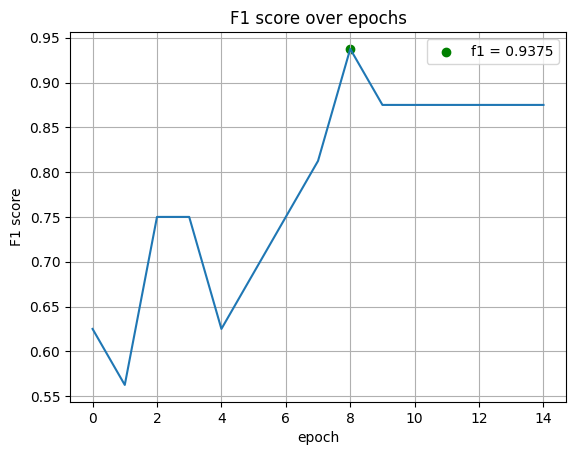

In [17]:
plt.plot(history['val_f1'])
plt.scatter(
    np.argmax(history['val_f1']),
    np.max(history['val_f1']),
    label = f"f1 = {np.max(history['val_f1'])}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix RAFT-ONE-STOP-ENGLISH')

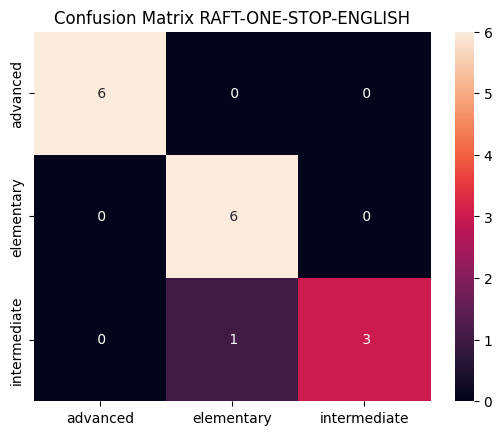

In [18]:
df = pd.DataFrame(
    history['val_conf_matrix'].to("cpu").numpy(),
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name}")

In [19]:
trainer.best_model.push_to_hub("peulsilva/RoBERTA-large-one-stop-english")

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/peulsilva/RoBERTA-large-one-stop-english/commit/f410c23cdfeae654c02078014ba965a579a089c8', commit_message='Upload RobertaForSequenceClassification', commit_description='', oid='f410c23cdfeae654c02078014ba965a579a089c8', pr_url=None, pr_revision=None, pr_num=None)

## Generating submission

In [20]:
test_dataset

Dataset({
    features: ['Article', 'ID', 'Label', 'labels'],
    num_rows: 516
})

In [21]:
test_dataset[0]

{'Article': 'Many of us know we don’t get enough sleep but imagine if there was a simple solution: getting up later. In a speech at the British Science Festival, Dr Paul Kelley from Oxford University said schools should stagger their starting times to work with the natural rhythms of their students. This would improve exam results and students’ health (lack of sleep can cause diabetes, depression, obesity and other health problems).\nDr Kelley said that, when children are around ten, their natural wake-up time is about 6.30am; at 16, this rises to 8am; and, at 18, a person’s natural waking hour is 9am, although you may think they are just a lazy teenager. The normal school starting time works for 10-year-olds but not for 16- to 18-year-olds. For the older teenagers, it might be better to start the school day at 11am or even later. “A 7am wake-up time for older teenagers,” says Kelley, “is the same as a 4.30am start for a teacher in their 50s.”\nHe says the solution is not to tell teena

In [30]:
model = trainer.best_model
submission = pd.DataFrame()

with torch.no_grad():
    for i in tqdm(range(len(test_dataset))):
        text = test_dataset[i]['Article']
        id = test_dataset[i]['ID']

        tokens = tokenizer(
            text,
            truncation= True,
            padding= "max_length",
            return_tensors= "pt",
            max_length=256,
        )

        for k,v in tokens.items():
            tokens[k] = v.to(device)

        pred = model(**tokens)\
            .logits\
            .argmax()\
            .to('cpu')\
            .item()

        this_row = pd.DataFrame({'ID' : id, "Label": pred}, index = [i])

        submission = pd.concat([submission, this_row],)

  0%|          | 0/516 [00:00<?, ?it/s]

100%|██████████| 516/516 [00:09<00:00, 52.80it/s]


In [31]:
class_label_keymap = { i-1: test_dataset.features['Label'].names[i] for i in range(num_classes +1)} 

In [32]:
class_label_keymap

{-1: 'Unlabeled', 0: 'advanced', 1: 'elementary', 2: 'intermediate'}

<Axes: ylabel='Frequency'>

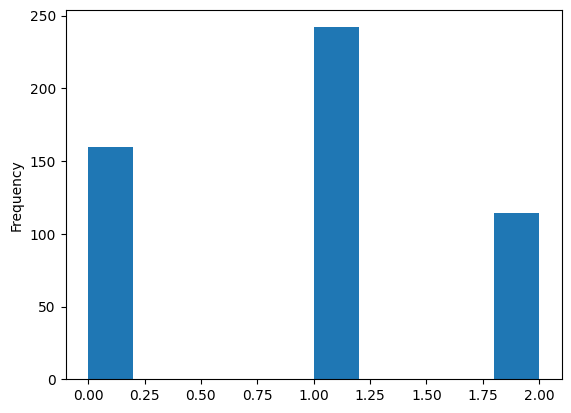

In [33]:
submission['Label'].plot.hist()

In [34]:
submission

,ID,Label
0,50,1
1,51,1
2,52,2
3,53,0
4,54,0
...,...,...
511,561,0
512,562,0
513,563,2
514,564,1


In [27]:
!mkdir submissions/finetuning/one_stop_english

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [35]:
submission['Label'] = submission['Label'].map(class_label_keymap)

submission.to_csv("submissions/finetuning/one_stop_english/predictions.csv", index = False)